In [307]:
import numpy as np
from scipy.fft import dct
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
import os
import time
%matplotlib inline


In [179]:
def get_DCT_matrix(size):
    '''Returns the normalised square matrix, used in the computation of the Discrete Cosine Transform
    
    Argument:
    size: the size of the matrix, which is the size of each basis vector. This must be equal to the length 
            of the signal to be transformed, obviously
    
    Returns:
    DCT_matrix: The required DCT matrix
    '''
    # initializing x and m
    x = np.arange(start = 0, stop = size).reshape(1, size) # row vector
    x = 2*x+1
    m = np.arange(start = 0, stop = size).reshape(size, 1) # column vector
    
    # the outer product
    matrix = np.dot(m,x)
    
    # taking the cosine
    DCT_matrix = np.cos(matrix* np.pi /2 / size)
    
    # normalizing, dividing each basis by its magnitude
    #DCT_matrix[0, :] *= np.sqrt(1/size)
    #DCT_matrix[1:,:] *= np.sqrt(2/size)
    
    return DCT_matrix

In [180]:
DCT_MATRIX = get_DCT_matrix(8)
# plt.imshow(DCT_matrix, cmap='gray')

In [181]:
def DCT_2D (in_block):
    '''computes the DCT transform of the incoming signal
    Arguments:
    in_block: the input 2D signal

    
    Returns:
    dct_coeff: The normalised DCT coefficients corresponding to this block
    '''
    
    # First some input validation
    row, col = in_block.shape
    assert (row == 8 and col == 8)
    
    #DCT computation
    Intermediate = np.dot(DCT_MATRIX, in_block)
    dct_coeff = np.dot(Intermediate, DCT_MATRIX.T)
    
    #scaling
    dct_coeff[0,0] /= 64
    dct_coeff[0,1:]/=32
    dct_coeff[1:,0] /= 32
    dct_coeff[1:,1:] /= 16
    
    return dct_coeff

In [182]:

def IDCT_2D(in_block):
    '''computes the IDCT transform of the incoming DCT coefficients block
    Arguments:
    in_block: the input 2D DCT coefficients

    
    Returns:
    inverted: The result of the IDCT
    '''
    # First some input validation
    row, col = in_block.shape
    assert (row == 8 and col == 8)
    
    #DCT computation
    
    Intermediate = np.dot(DCT_MATRIX.T, in_block)
    inverted = np.dot(Intermediate, DCT_MATRIX)
    
    return inverted

In [183]:
# testing the DCT/IDCT pair
# generate the array
x = np.random.randn(8,8)* 100
# generate the DCT matrix
big_x = DCT_2D(x)
# get the IDCT
ret_x = IDCT_2D(big_x)
# get the Sum of abs errors
error_2 = np.sum(abs(ret_x-x))
print("The sum of absolute errors is:",error_2)

The sum of absolute errors is: 3.74023034765969e-12


In [295]:
def generate_qtable(base_qtable, q_factor):
    """
    Generate a JPEG quantization table for a given quality factor.
    
    Args:
        base_qtable (np.ndarray): Base quantization table.
        q_factor (int): Quality factor (1 to 100).
    
    Returns:
        np.ndarray: Scaled quantization table.
    """
    # Compute scaling factor
    scale = 50 / q_factor if q_factor < 50 else 2 - q_factor / 50
    # Scale and clip the quantization table
    scaled_qtable = np.clip(base_qtable * scale, 1, 255)
    return np.round(scaled_qtable).astype(int)


# Standard JPEG Quantization Table for Luminance
BASE_QTABLE = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])




In [ ]:
def divide_quant(block, q_table):
    '''Divides the each element in the block by the corresponding element in the Quantization table, then rounds
    
    Arguments:
    block: The block to be divided by the table
    q_table: The Quantization table "ones by default"
    
    Returns: The result of dividing, then rounding
    '''
    res = block / q_table
    res = res.astype(np.int64) # rounding
    return res

In [ ]:
# At the decoder, we multiply by the Q_table
def multiply_quant(block, q_table):
    return block * q_table

In [226]:
def get_ZigZag_indices(size):
    '''Returns the order of indeces to be parsed in zigzag parsing
    
    Arguments:
    size: The size of the square matrix to be parsed
    
    Returns:
    indeces: indeces ordered according to zigzag parsing
    '''
    
    # this will hold the first half
    indeces = []
    # this will hold the second half indeces
    reversed_indeces = []
    
    for i in range(size):
        for j in range(i+1):
            # if odd
            if i%2 != 0:
                indeces.append((j, i-j))
                reversed_indeces.append((size-1-j, size-1-i+j))
            # if even
            else:
                indeces.append((i-j, j))
                reversed_indeces.append((size-1-i+j,size-1-j))
    
    # reverse
    reversed_indeces = reversed_indeces[::-1]
    # exclude the main diagonal part because it is repeated
    indeces = indeces[:-size]
    # merge the two lists
    indeces.extend(reversed_indeces)
    
    return indeces

In [227]:
# the ZIGZAG indices will be a global variable.
ZIG_ZAG_INDICES = get_ZigZag_indices(8)
ZIG_ZAG_ROW, ZIG_ZAG_COL = zip(* ZIG_ZAG_INDICES)

In [228]:
def encode_runlength(array):
    '''Returns the encoded array using runlength code
    The function will apply runlength to "0" because it is the most occuring element 
    
    Arguments:
    array: a 1D numpy array to be encoded
    
    Returns: a 1D list, encoded using runlength
    '''
    encoded = []
    counter = 0
    
    # this for loop will handle zeros that are interrupted before array ends
    for element in array:
        if (element == 0):                          #if element is zero, increment counter
            counter += 1
        else:                                       # if not, check if we were in a zero sequence
            if (counter != 0):
                # zero sequence interrupted
                encoded.extend([0, counter])
                # reset counter
                counter = 0
            
            # add the non zero element to the array 
            encoded.append(element)
            
    # This handles trailing zeros
    if counter != 0:
        encoded.extend([0, counter])
    return encoded

In [229]:
arr = np.random.randint(2, size = 10)
enc = encode_runlength(arr)
print("original array is", arr,"with length", len(arr))
print("encoded sequence is", enc, "with length", len(enc))

original array is [0 0 0 0 0 1 1 1 0 0] with length 10
encoded sequence is [0, 5, 1, 1, 1, 0, 2] with length 7


In [230]:
def decode_runlength(array):
    '''Decodes the runlength code of zeros
    Argument:
    array: a 1D numpy array of runlength code
    
    Returns: The original 1D sequence as a numpy array
    '''
    decoded = []
    index = 0
    while index < len(array):
        if array[index] == 0:                # zero detected
            count = array[index+1]
            # recreate the zero sequence
            zero_seq = [0]*count
            # append the zero sequence
            decoded.extend(zero_seq)
            # update the index by 2 to bypass the count
            index+=2
        else:                               # not a zero
            decoded.append(array[index])
            index += 1
    return np.array(decoded)

In [231]:
dec = decode_runlength(enc)
print("The decoded sequence is", dec)
print("Is the decoded the same as the original? ")
all(dec == arr)

The decoded sequence is [0 0 0 0 0 1 1 1 0 0]
Is the decoded the same as the original? 


True

In [232]:
array = [0,0,0,1,1,2,1]

encoded_str, huff_tree, huff_dict, symbo_dict = encode_huffman(array)
huff_tree.display()

                                ______________________________1.0___________           
                               /                                            \          
            __________0.5714285714285714___________              1: 0.42857142857142855
           /                                       \                                   
0: 0.42857142857142855                  2: 0.14285714285714285                         


In [233]:
decode_huffman(encoded_str, huff_tree)

[0, 0, 0, 1, 1, 2, 1]

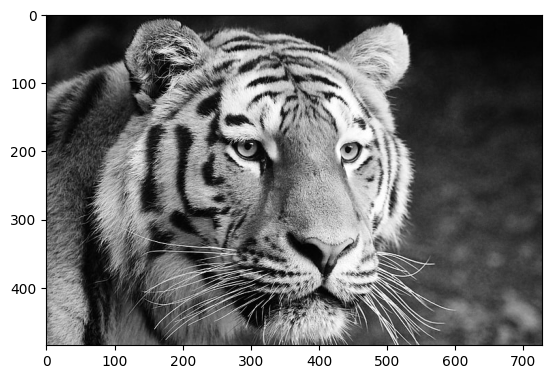

In [243]:
img_path = "ex2.jpg"
# changing image to grayscale
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')

In [244]:
print("the image size is", image.shape)

the image size is (485, 728)


In [245]:
def pad_image(image):
    '''Zero pads the image if necessary to be composed of 8x8 blocks
    
    Arguments: 
    image: a 2D numpy matrix 
    
    Returns:
    padded_image: a padded image with both dimensions as multiples of 8
    '''
    
    #initializing the padded dims to rows and cols
    row_padded, col_padded = image.shape
    
    #padding the rows if they are not multiples of 8
    if (row_padded % 8 != 0):
        row_padded = row_padded + (8 - row_padded % 8)
    #padding the cols 
    if (col_padded % 8 != 0):
        col_padded = col_padded + (8 - col_padded % 8)
    
    # if no padding happened, return the original image
    if (row_padded, col_padded) == image.shape:
        return image
    
    (row, col) = image.shape
    # initialize with new dims
    padded_image = np.zeros((row_padded, col_padded))
    
    # assign the old image to its right place
    padded_image[0:row, 0:col] = image
    
    return padded_image

In [246]:
def blockify(image):
    '''Returns a list of image blocks
    Arguments:
    image: a 2D matrix representing a matrix
    
    Returns
    blocks: a list of 8x8 blocks
    '''
    # zero pad if necessary
    image_padded = pad_image(image)
    # initialize the blocks list
    blocks = []
    # find out the number of blocks across each dim
    row, col = image_padded.shape
    n_block_row = int(row/8)
    n_block_col = int(col/8)
    # unenroll
    for i in range(n_block_row):
        for j in range(n_block_col):
            current_block = image_padded[i*8: (i+1)*8, j*8: (j+1)*8]
            blocks.append(current_block)
    
    return blocks, image_padded.shape

In [247]:
blocks,_ = blockify(image)
blocks[0]

array([[ 7.,  8.,  8.,  9., 10., 11., 12., 13.],
       [ 6.,  7.,  7.,  8.,  9., 10., 11., 11.],
       [ 5.,  6.,  6.,  7.,  8.,  9., 10., 10.],
       [ 5.,  5.,  6.,  7.,  8.,  9., 10., 10.],
       [ 6.,  6.,  7.,  8.,  9., 10., 10., 11.],
       [ 6.,  6.,  7.,  8.,  9., 10., 11., 11.],
       [ 6.,  6.,  7.,  8.,  9., 10., 10., 11.],
       [ 5.,  6.,  6.,  7.,  8.,  9., 10., 10.]])

In [248]:
def encode_JPEG(image, q_table = ONES_TABLE):
    '''Performs JPEG compression on the image
    
    Arguments:
    image: a 2D matrix representing the grayscale image
    q_table: The qunatization table used while compressing
    
    Returns:
    huff_stream: The stream of bits obtained from the Huffman encoding
    huff_tree: The tree that holds the coding scheme. Essential for decoding
    huff_dict: A dictionary which maps each symbol to its assigned code by the Huffman code
    padded_shape: The size of the padded image. Will be usefull for reconstructing the image
    '''
    # dividing into blocks
    blocks, padded_shape = blockify(image)
    
    # initializing the stream
    stream = []
    # for each block
    for block in blocks:
        # applying 2D DCT
        DCT_block = DCT_2D(block)
        
        # dividing by quantization matrix
        q_block = divide_quant(DCT_block, q_table)
        
        # zigzag unrolling or spreading
        vector = q_block[ZIG_ZAG_ROW, ZIG_ZAG_COL]
        
        # Runlength
        rn_vector = encode_runlength(vector)
        
        # appending to stream
        stream.extend(rn_vector)
    
    # Now that we have the stream, apply huffman encoding
    huff_stream, huff_tree, huff_dict, symb_dict = encode_huffman(stream)
    
    return huff_stream, huff_tree, huff_dict, symb_dict, padded_shape

In [249]:
hf_stream, hf_tree, hf_dict, symbol_dict, image_dims = encode_JPEG(image)
len(hf_stream)

1040656

In [250]:
print("Compression ratio is {}".format(image.shape[0] * image.shape[1] * 8 / len(hf_stream)))

Compression ratio is 2.7142879107024798


In [257]:
def decode_jpeg(hf_stream, hf_tree, image_dims, q_table = ONES_TABLE):
    '''Decodes a Huffman stream into a 2D representation of grayscale image
    Arguments:
    hf_stream: The Stream of bits obtained from huffman code
    hf_tree: The Huffman tree to be used in decoding
    image_dims: The dimension of the image to be decoded
    q_table: The qunatization table that will be multipllied by each block before IDCT
    
    Returns:
    ret_image: The 2D decoded image
    '''
    # init the returned image
    ret_image = np.empty(image_dims)
    
    # The number of blocks along the columns
    n_block_col = int(image_dims[1]/8)
    
    # decode the huffman stream
    dec_hf = decode_huffman(hf_stream, hf_tree)
    
    # runlength decode
    dec_rn = decode_runlength(dec_hf)
    
    # Divide the decoded runlength into chunks of 64 elements
    # each rolled chunk will be multiplied by q_table and grouped into a decoded image
    n_chunks = int(len(dec_rn)/64)
    
    for i in range(n_chunks):
        chunk = dec_rn[i * 64: (i+1)*64]
        
        # roll it into a 2D matrix
        rolled = np.empty((8,8))
        rolled[ZIG_ZAG_ROW, ZIG_ZAG_COL] = chunk
        
        # multiply by q_table
        rolled = rolled * q_table
        
        # IDCT and grouping
        row_index = int(i/n_block_col)
        col_index = i %n_block_col
        ret_image[row_index*8: (row_index+1)*8, col_index*8: (col_index+1)*8] = IDCT_2D(rolled)
        # resize the image to the original size
        ret_image = ret_image[:image_dims[0], :image_dims[1]]
    
    return ret_image

In [258]:
h_stream, h_tree, h_dict, sym_dict, dims = encode_JPEG(image, q_table=LOW_COMPRESSION_MAT)
dec = decode_jpeg(h_stream, h_tree, dims, q_table=LOW_COMPRESSION_MAT)

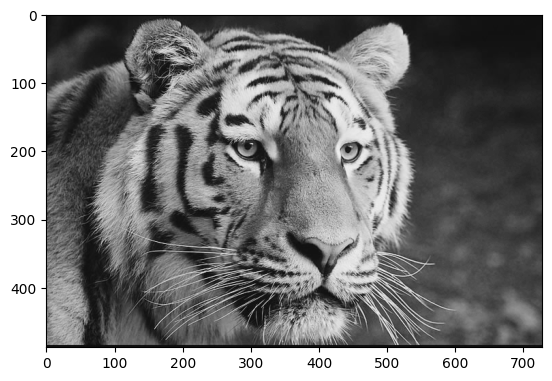

In [259]:
plt.imshow(dec, cmap="gray")

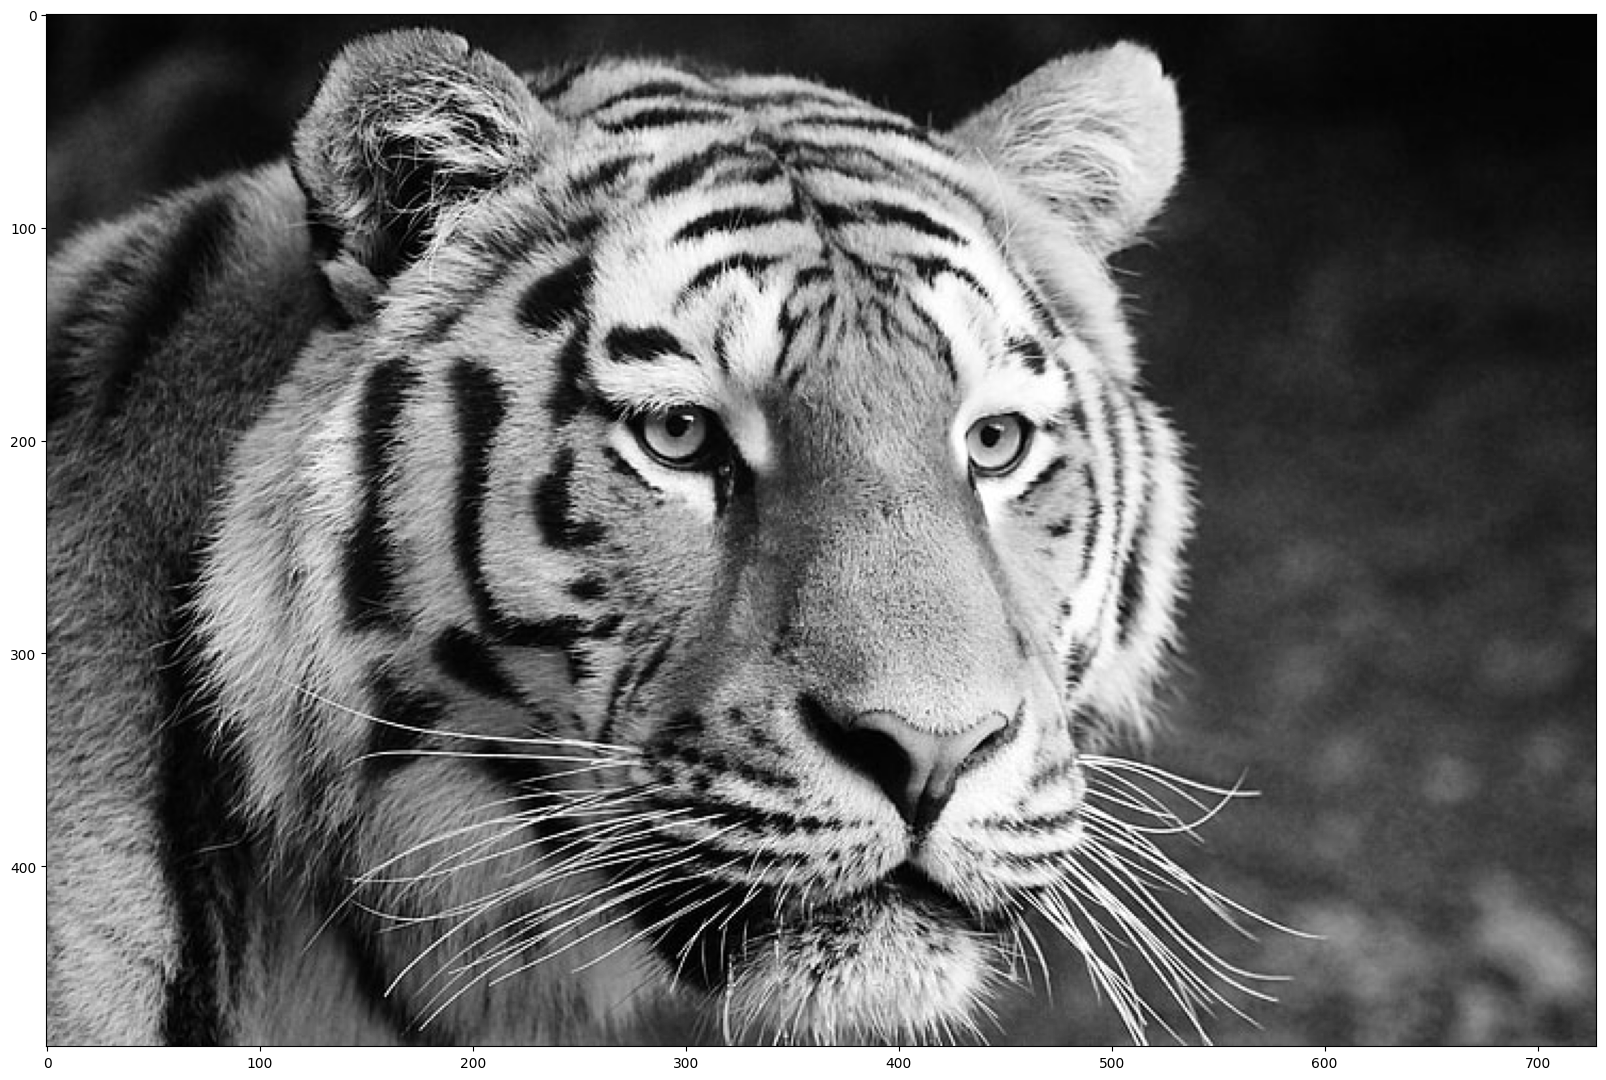

In [260]:
from PIL import Image
# converting it to grayscale 
hd_image = Image.open("ex2.jpg").convert("L")
hd_image = np.array(hd_image)
# Now we save it for reference
gray_hd = Image.fromarray(hd_image)
gray_hd.save("gray_hd.jpg")
# Now we display it
plt.figure(figsize=(20,20))
plt.imshow(hd_image, cmap = "gray")

In [261]:
hd_image.shape

(485, 728)

The code took 0.45843935012817383 seconds
Compression ratio is 2.7310773204594025
The RMSE is 1.8990578152491058


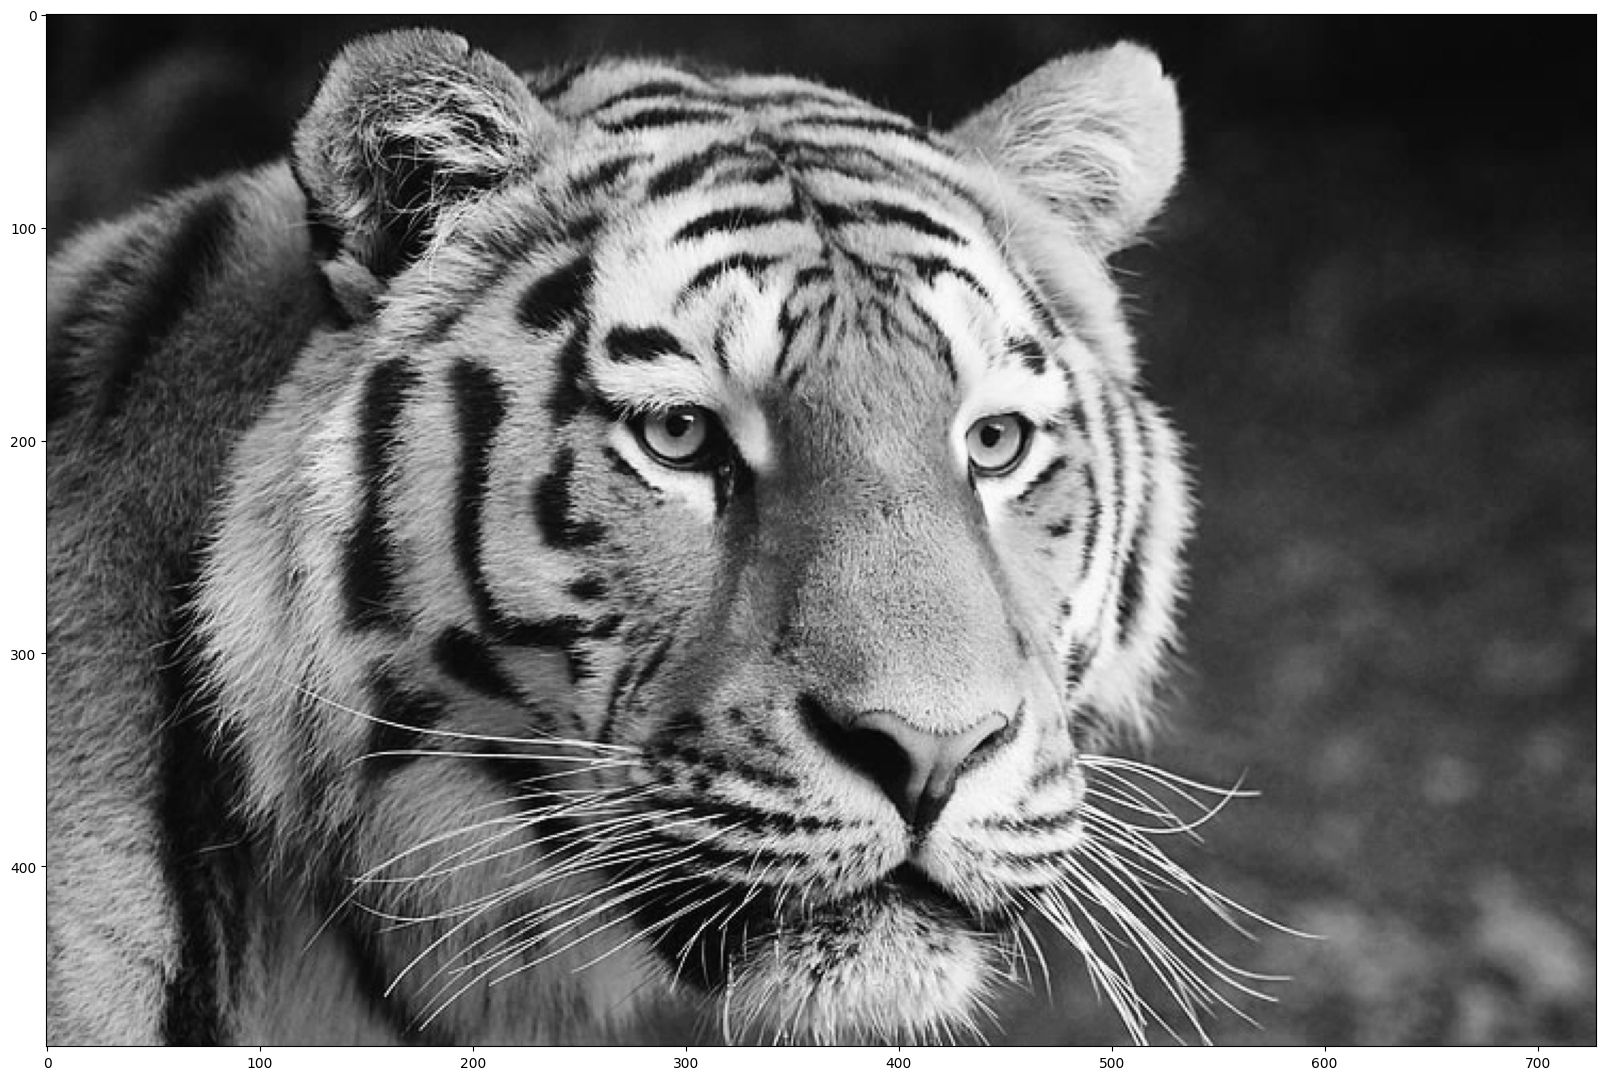

In [272]:
t = time.time()
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table=ONES_TABLE)

ret_image = decode_jpeg(hf_str, hf_tree, dims)
# ret_image.shape
# changing the ret_image such that the zero padding is removed
ret_image = ret_image[:hd_image.shape[0], :hd_image.shape[1]]

t =  time.time() - t
print("The code took {} seconds".format(t))
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(20,20))
plt.imshow(ret_image, cmap ="gray")

In [273]:
# calculating bpp for the image
bpp = len(hf_str) / dims[0] / dims[1]
bpp

2.929246982525671

In [306]:
def calculate_rmse(original, compressed):
    """Compute the Root Mean Squared Error (RMSE) between two images."""
    return np.sqrt(np.mean((original - compressed) ** 2))

def calculate_bpp(file_size_bytes, image_shape):
    """Compute Bits Per Pixel (BPP) for the compressed image."""
    total_pixels = image_shape[0] * image_shape[1]
    return (file_size_bytes * 8) / total_pixels

In [312]:
os.makedirs("my_output", exist_ok=True)

Text(0.5, 1.0, 'RMSE vs BPP for different Quality Factors')

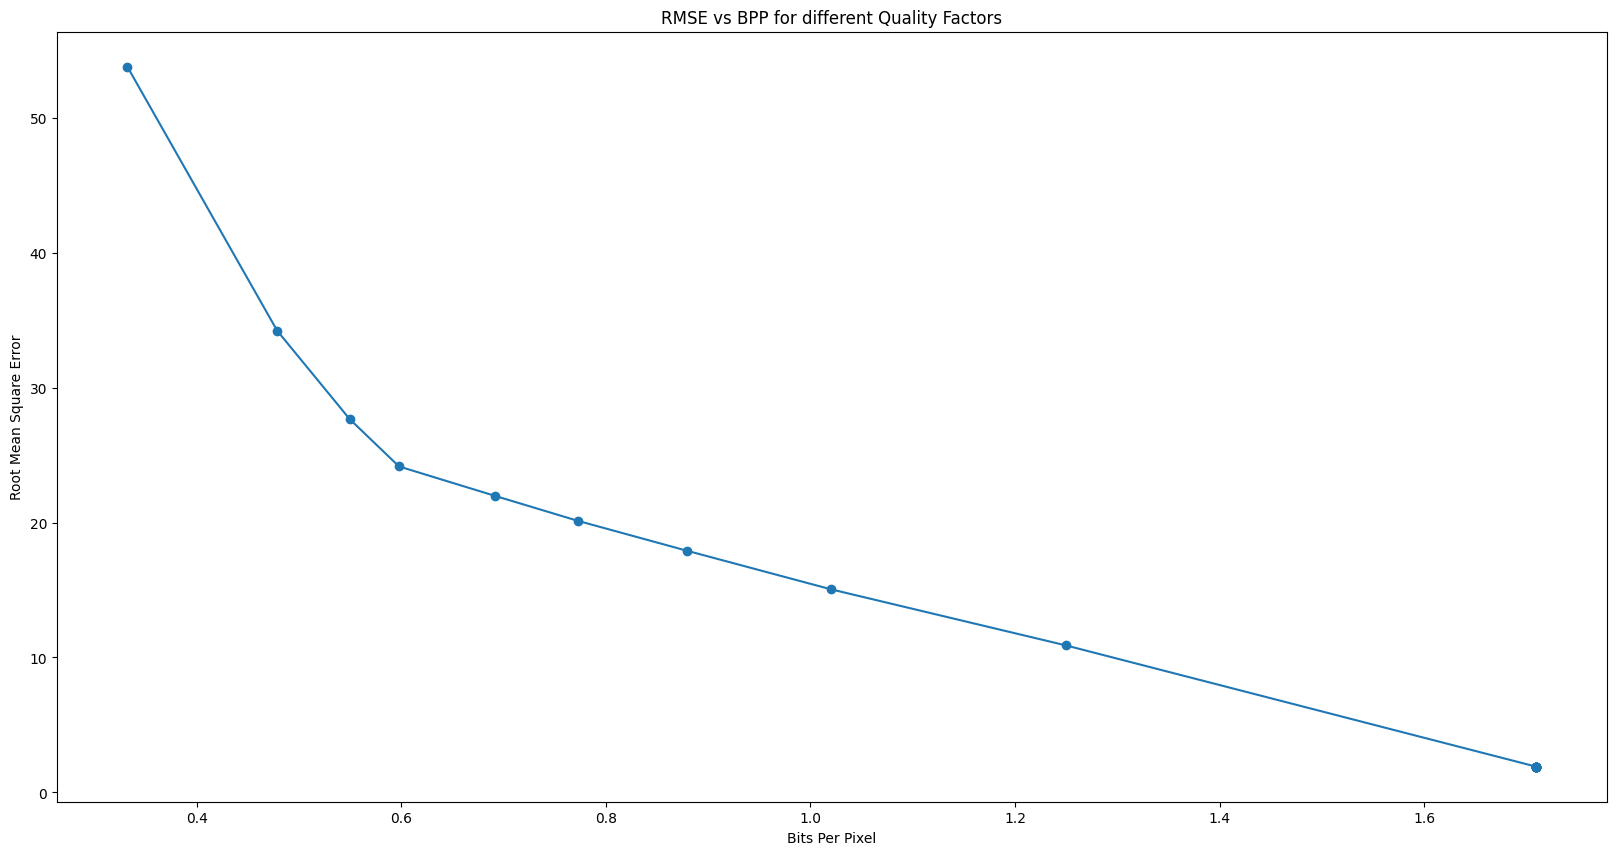

In [ ]:
# the quality factors
q_factors = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,120,130,140,150,160,170,180,190,200]


# the quantization table
q_tables = {q_factor: generate_qtable(BASE_QTABLE, q_factor) for q_factor in q_factors}
# the images
image = hd_image

# the results will be stored in a dictionary

results = {}

for q_factor,q_table in q_tables.items():
    # encoding
    hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(image, q_table=q_table)
    # print(hf_str)
    
    # decoding
    ret_image = decode_jpeg(hf_str, hf_tree, dims, q_table=q_table)
    # saving the image
    path = os.path.join("my_output", f"image_{q_factor}.jpg")
    mpimg.imsave(path, ret_image)
    size = os.path.getsize(path)
    # removing the zero padding
    ret_image = ret_image[:image.shape[0], :image.shape[1]]
    # calculating the RMSE
    rmse = calculate_rmse(image, ret_image)
    # calculating the bpp
    bpp = calculate_bpp(size, image.shape)

    # ret_image file size in bytes
    

    rmse_2 = calculate_bpp()
    # print("Quality Factor {}:".format(q_factor))
    # print("RMSE: ", rmse)
    # print("BPP: ", bpp)
    # print("\n")
    # storing the results
    results[q_factor] = {"RMSE": rmse, "BPP": bpp, "Image": ret_image}


# plotting rmse vs bpp for every quality factor
plt.figure(figsize=(20,10))
bpps = []
rmses = []
for q_factor in q_factors:
    bpps.append(results[q_factor]["BPP"])
    rmses.append(results[q_factor]["RMSE"])

# plot the BPP vs RMSE and marking the points 
plt.plot(bpps, rmses, label = "Quality Factor", marker = "o")
    # plt.plot(results[q_factor]["BPP"], results[q_factor]["RMSE"])
#     # print("Quality Factor {}:".format(q_factor))
#     # print("RMSE: ", results[q_factor]["RMSE"])
#     # print("BPP: ", results[q_factor]["BPP"])
#     # print("\n")
plt.xlabel("Bits Per Pixel")
plt.ylabel("Root Mean Square Error")
# plt.legend()
plt.title("RMSE vs BPP for different Quality Factors")

# results


In [318]:
import numpy as np
import cv2
import matplotlib.pyplot as plt



def actual_jpeg_compression(image_path, output_dir, quality_levels):
    """
    Perform compression using actual JPEG algorithm and calculate RMSE and BPP.
    
    Args:
        image_path (str): Path to the original image.
        output_dir (str): Directory to save compressed JPEG images.
        quality_levels (list[int]): List of JPEG quality levels to test.
    
    Returns:
        list[float], list[float]: RMSE values and corresponding BPP values.
    """
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h, w = original.shape
    
    rmse_values = []
    bpp_values = []
    
    for quality in quality_levels:
        # Save the image using OpenCV with the specified quality
        compressed_path = os.path.join(output_dir, f"compressed_q{quality}.jpg")
        cv2.imwrite(compressed_path, original, [cv2.IMWRITE_JPEG_QUALITY, quality])
        
        # Load the compressed image
        compressed = cv2.imread(compressed_path, cv2.IMREAD_GRAYSCALE)
        
        # Calculate RMSE
        rmse = calculate_rmse(original, compressed)
        rmse_values.append(rmse)
        
        # Calculate BPP
        file_size = os.path.getsize(compressed_path)  # File size in bytes
        bpp = calculate_bpp(file_size, (h, w))
        bpp_values.append(bpp)
    
    return rmse_values, bpp_values



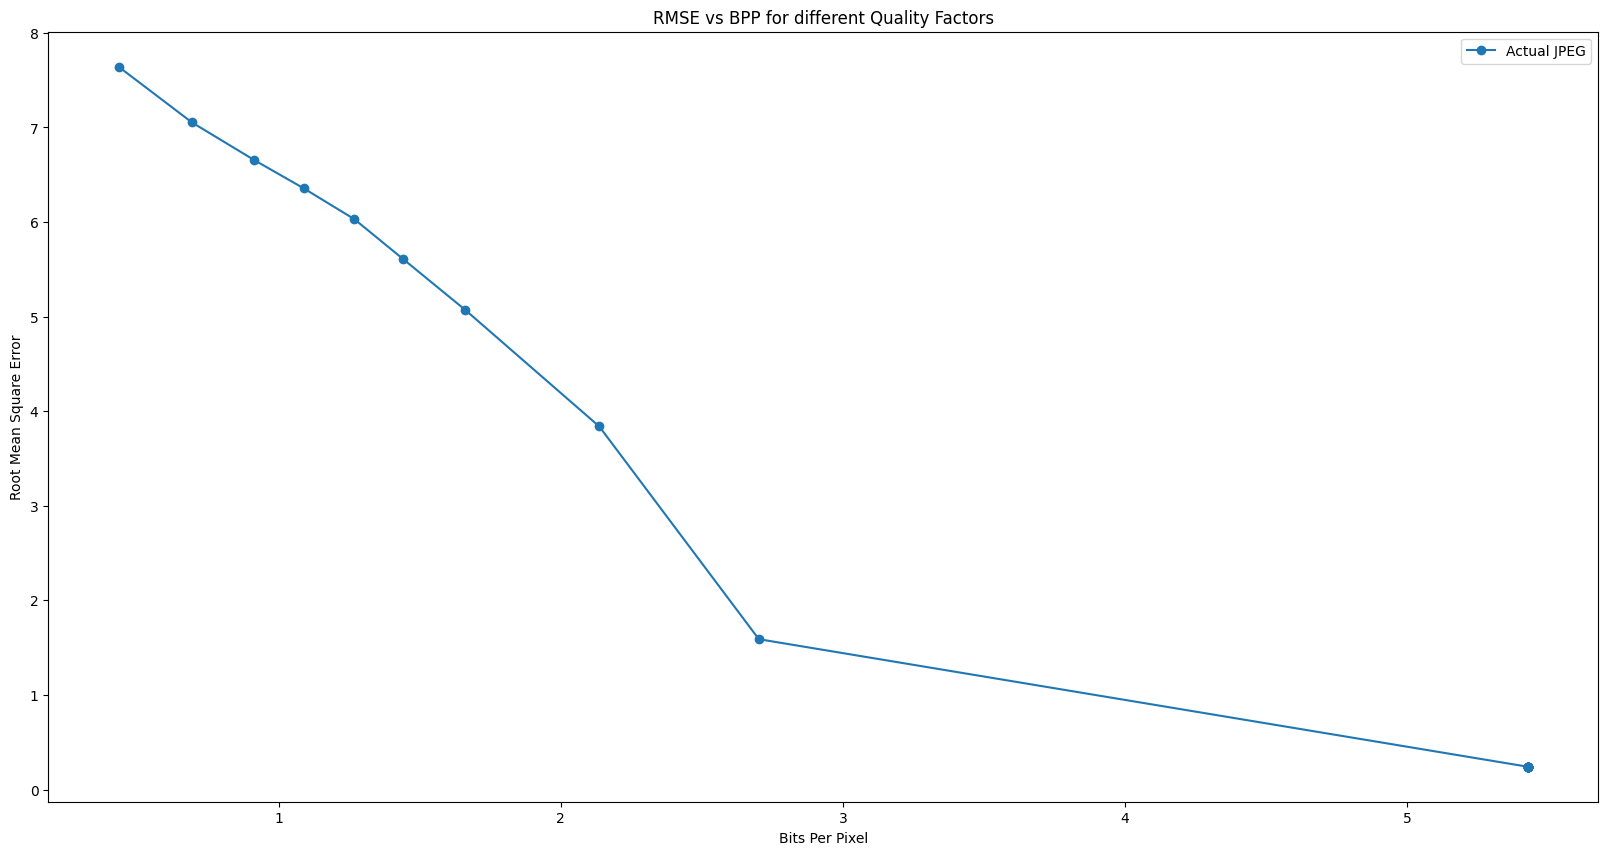

In [319]:
os.makedirs("output", exist_ok=True)
actual_rmse, actual_bpp = actual_jpeg_compression("ex2.jpg", "output", q_factors)
plt.figure(figsize=(20,10))
plt.plot(actual_bpp, actual_rmse, label="Actual JPEG", marker="o")
plt.xlabel("Bits Per Pixel")
plt.ylabel("Root Mean Square Error")
plt.title("RMSE vs BPP for different Quality Factors")
plt.legend()
plt.show()

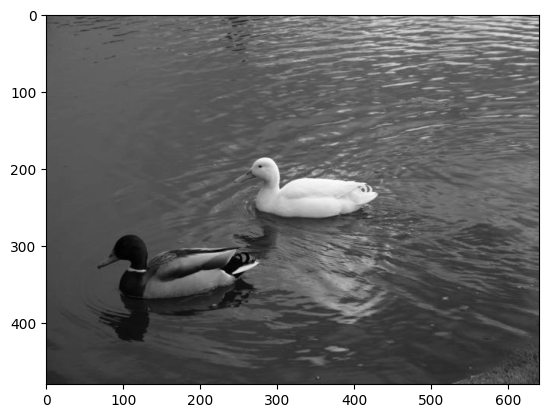

In [332]:
import glob
folder = "../Microsoft-Database/birds"
images = glob.glob(folder + "/*.JPG")

imgs = []
for img in images:
    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    imgs.append(image)

plt.imshow(imgs[0], cmap="gray")


In [330]:
birds
